# Asset Class Hierarchical Clustering

### Introduction 
In this analysis, I will be hierarchically clustering major asset classes in the investment landscape, using their correlations as a measure of distance (i.e., dissimilarity). These correlations&mdash;both monthly and quarterly&mdash;will be derived using the historical return streams of various ETFs, which will serve as proxies for these asset classes; using ETFs as opposed to actual indices allows historical data to be easily retrieved with an open-source API (here, I used Alpha Vantage's). After the converting the correlation matrices into distance matrices, clustering will be performed by SciPy's linkage function, which, as opposed to scikit-learn's AgglomerativeClustering class, is natively plottable as a dendrogram. Average linkage will be the metric by which distances between clusters are updated as they grow. Ultimately, the results of this analysis will provide a clearer picture of how different asset classes relate to one another; this can in turn lead to better investing, as possessing a range of uncorrelated assets mitigates downside risk and provides additional robustness to an overall investment strategy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import requests
import time

Asset classes to cluster (ETF proxy - Ticker):

- **Equities**
    - Global Equity (iShares MSCI ACWI ETF - ACWI)
    - U.S. Equity (iShares Russell 3000 ETF - IWV)
    - Developed Market ex US Equity (iShares MSCI EAFE ETF - EFA)
    - Emerging Market Equity (iShares MSCI EM ETF - EEM)
    - European Equity (iShares Core MSCI Europe ETF - IEUR)
    - Pacific Equity (iShares Core MSCI Pacific ETF - IPAC)
- **Fixed Income**
    - U.S. Core Fixed Income (iShares Core U.S. Aggregate Bond ETF - AGG)
    - U.S. High Yield Bonds (iShares iBoxx \$ High Yield Corporate Bond ETF - HYG)
    - U.S. TIPS (iShares TIPS Bond ETF - TIP)
    - Intermediate U.S. Investment Grade Credit (Vanguard Intermediate-Term Corporate Bond ETF - VCIT)
    - Long U.S. Investment Grade Credit (Vanguard Long-Term Corporate Bond ETF - VCLT)
    - Intermediate U.S. Government Bonds (Vanguard Intermediate-Term Treasury ETF - VGIT)
    - Long U.S. Government Bonds (Vanguard Long-Term Treasury ETF - VGLT)
    - Long STRIPS (Vanguard Extended Duration Treasury ETF - EDV)
- **Real Assets**
    - Real Estate (Vanguard Real Estate ETF - VNQ)
    - Oil & Gas (iShares Global Energy ETF - IXC)
    - Renewable Energy (iShares Global Clean Energy ETF - ICLN)
    - Gold (iShares Gold Trust ETF - IAU)
    - Silver (iShares Silver Trust ETF - SLV)
- **Private Equity (Invesco Global Listed Private Equity ETF - PSP)**

### Fetching historical ETF price data using API from Alpha Vantage (resultant csv imported in next section)

(Note: if csv is already available, this section can be skipped.)

In [ ]:
asset_class_to_ticker_dict = {
    'Global Equity': 'ACWI',
    'U.S. Equity': 'IWV',
    'Dev ex U.S. Equity': 'EFA',
    'EM Equity': 'EEM',
    'European Equity': 'IEUR',
    'Pacific Equity': 'IPAC',
    'U.S. Core Fixed Income': 'AGG',
    'U.S. High Yield Bonds': 'HYG',
    'U.S. TIPS': 'TIP',
    'Intermediate Credit': 'VCIT',
    'Long Credit': 'VCLT',
    'Intermediate Treasury': 'VGIT',
    'Long Treasury': 'VGLT',
    'Long STRIPS': 'EDV',
    'Real Estate': 'VNQ',
    'Oil & Gas': 'IXC',
    'Renewable Energy': 'ICLN',
    'Gold': 'IAU',
    'Silver': 'SLV',
    'Private Equity': 'PSP' 
}

In [ ]:
base_url = 'https://www.alphavantage.co/query'
api_key = 'XXXXXXXXXXXXXXXX'

total_ticker_prices_df = pd.DataFrame()

for ticker in asset_class_to_ticker_dict.values():
    r = requests.get(base_url, params={'function': 'TIME_SERIES_MONTHLY', 
                                       'symbol': ticker, 'datatype': 'json', 
                                       'apikey': api_key})
    try:
        r.raise_for_status() # Could throw HTTPError
        time_series_data_dict = r.json()['Monthly Time Series'] # Could throw KeyError
    except (requests.exceptions.HTTPError, KeyError) as e:
        print(f'Error with {ticker}: {repr(e)}')
        continue

    dates = []
    closes = []
    for key, val in time_series_data_dict.items():
        dates.append(key)
        closes.append(val['4. close']) # Closing price
        
    individual_ticker_prices_df = pd.DataFrame({ticker: closes}, index=dates)
    total_ticker_prices_df = pd.concat([total_ticker_prices_df, 
                                        individual_ticker_prices_df], axis=1)
    time.sleep(30)

total_ticker_prices_df.to_csv('total_ticker_prices_df.csv')   
total_ticker_prices_df

### Exploring and manipulating historical price data

In [2]:
total_ticker_prices_df = pd.read_csv('../data/total_ticker_prices_df.csv', 
                                     index_col=0)

total_ticker_prices_df

,ACWI,IWV,EFA,EEM,IEUR,IPAC,AGG,HYG,TIP,VCIT,VCLT,VGIT,VGLT,EDV,VNQ,IXC,ICLN,IAU,SLV,PSP
2022-09-15,84.75,226.71,60.77,38.14,43.44,51.12,98.90,73.95,110.16,78.34,78.19,59.38,66.15,92.75,90.28,36.70,22.19,31.58,17.63,9.67
2022-08-31,85.90,229.11,61.70,39.43,43.73,52.73,100.71,74.53,113.91,79.63,80.32,60.40,68.50,96.56,93.01,36.90,22.18,32.46,16.58,9.98
2022-07-29,89.82,238.01,65.72,39.96,47.28,54.98,104.07,78.19,118.23,82.96,85.25,62.25,71.85,101.80,98.96,36.25,22.29,33.45,18.70,10.89
2022-06-30,83.89,217.39,62.49,40.10,44.96,51.99,101.68,73.61,113.91,80.02,81.11,61.16,70.16,100.13,91.11,33.88,19.05,34.31,18.64,9.82
2022-05-31,92.14,238.12,70.01,42.64,51.06,57.06,103.47,79.50,118.94,82.45,85.35,61.63,71.27,101.57,99.07,40.43,19.88,34.87,19.84,11.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-10-31,NaN,78.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-29,NaN,80.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-31,NaN,84.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-07-31,NaN,78.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
total_ticker_prices_df.index = pd.to_datetime(total_ticker_prices_df.index)

# Dropping most recent non-month-end entry
total_ticker_prices_df = total_ticker_prices_df.drop('2022-09-15', axis=0)

# Reordering index in ascending order
total_ticker_prices_df = total_ticker_prices_df.sort_index()

total_ticker_prices_df

,ACWI,IWV,EFA,EEM,IEUR,IPAC,AGG,HYG,TIP,VCIT,VCLT,VGIT,VGLT,EDV,VNQ,IXC,ICLN,IAU,SLV,PSP
2000-06-30,NaN,78.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-07-31,NaN,78.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-31,NaN,84.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-29,NaN,80.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-10-31,NaN,78.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,91.73,238.68,68.64,42.38,49.97,56.46,102.87,78.53,121.07,81.57,84.10,61.29,72.88,105.84,103.94,35.48,18.84,36.04,21.04,11.27
2022-05-31,92.14,238.12,70.01,42.64,51.06,57.06,103.47,79.50,118.94,82.45,85.35,61.63,71.27,101.57,99.07,40.43,19.88,34.87,19.84,11.44
2022-06-30,83.89,217.39,62.49,40.10,44.96,51.99,101.68,73.61,113.91,80.02,81.11,61.16,70.16,100.13,91.11,33.88,19.05,34.31,18.64,9.82
2022-07-29,89.82,238.01,65.72,39.96,47.28,54.98,104.07,78.19,118.23,82.96,85.25,62.25,71.85,101.80,98.96,36.25,22.29,33.45,18.70,10.89


In [4]:
total_ticker_returns_df = total_ticker_prices_df.pct_change()
total_ticker_returns_df

,ACWI,IWV,EFA,EEM,IEUR,IPAC,AGG,HYG,TIP,VCIT,VCLT,VGIT,VGLT,EDV,VNQ,IXC,ICLN,IAU,SLV,PSP
2000-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-07-31,NaN,-0.007471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-31,NaN,0.073871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-29,NaN,-0.041583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-10-31,NaN,-0.022437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,-0.080677,-0.090292,-0.067391,-0.061351,-0.064232,-0.072906,-0.039496,-0.045692,-0.028097,-0.051953,-0.102167,-0.025751,-0.093532,-0.130463,-0.040878,-0.018534,-0.124535,-0.021450,-0.080420,-0.125679
2022-05-31,0.004470,-0.002346,0.019959,0.006135,0.021813,0.010627,0.005833,0.012352,-0.017593,0.010788,0.014863,0.005547,-0.022091,-0.040344,-0.046854,0.139515,0.055202,-0.032464,-0.057034,0.015084
2022-06-30,-0.089538,-0.087057,-0.107413,-0.059568,-0.119467,-0.088854,-0.017300,-0.074088,-0.042290,-0.029472,-0.049678,-0.007626,-0.015575,-0.014177,-0.080347,-0.162008,-0.041751,-0.016060,-0.060484,-0.141608
2022-07-29,0.070688,0.094853,0.051688,-0.003491,0.051601,0.057511,0.023505,0.062220,0.037925,0.036741,0.051042,0.017822,0.024088,0.016678,0.086160,0.069953,0.170079,-0.025066,0.003219,0.108961


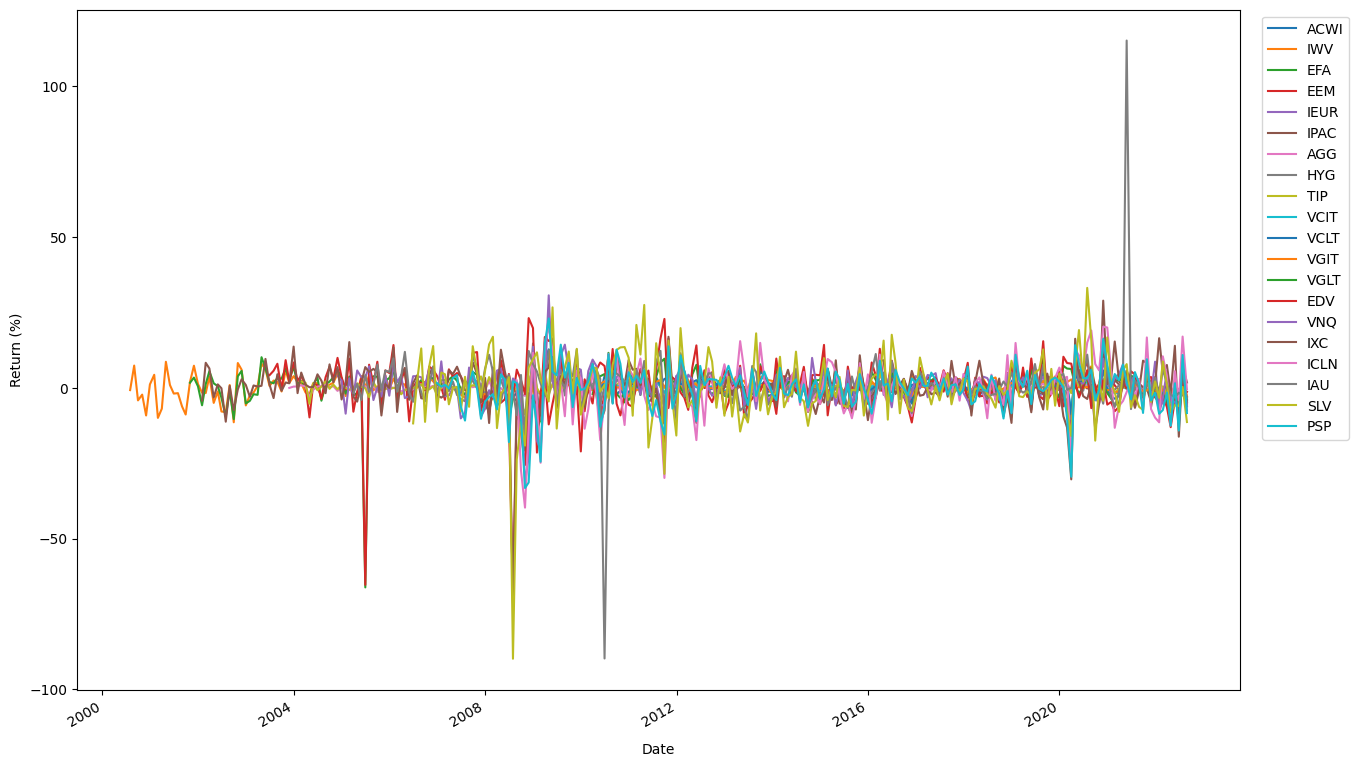

In [5]:
# Visualizing returns

fig, ax = plt.subplots(figsize=(15, 10))

(total_ticker_returns_df*100).plot(ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1))
ax.set_ylabel('Return (%)')
ax.set_xlabel('Date', labelpad=10)
plt.show()

In [6]:
lcp_returns = total_ticker_returns_df.dropna(how='any')
lcp_returns.head()

,ACWI,IWV,EFA,EEM,IEUR,IPAC,AGG,HYG,TIP,VCIT,VCLT,VGIT,VGLT,EDV,VNQ,IXC,ICLN,IAU,SLV,PSP
2014-08-29,0.025762,0.042566,0.001802,0.028298,0.003370,-0.007133,0.009639,0.019031,0.002959,0.011960,0.028778,0.010063,0.040354,0.069755,0.030441,0.024742,0.052726,0.003221,-0.044433,0.011504
2014-09-30,-0.033158,-0.024881,-0.038825,-0.077674,-0.041102,-0.040583,-0.007911,-0.024300,-0.027592,-0.015835,-0.033157,-0.007628,-0.021976,-0.037379,-0.069059,-0.079572,-0.077250,-0.060995,-0.126136,-0.064869
2014-10-31,0.012054,0.027057,-0.002651,0.014196,-0.022411,0.032180,0.007130,0.006308,0.009012,0.006109,0.015550,0.008078,0.022206,0.041937,0.099374,-0.046305,-0.038638,-0.029915,-0.051988,0.000000
2014-11-28,0.013756,0.024760,0.000625,-0.015421,0.021367,-0.038627,0.006570,-0.015130,0.001592,0.007254,0.006028,0.007233,0.024592,0.043406,0.020003,-0.086821,-0.020861,-0.005286,-0.043226,0.026126
2014-12-31,-0.031938,-0.005125,-0.049226,-0.053253,-0.046851,-0.035692,-0.004430,-0.016789,-0.011037,-0.009434,0.010496,-0.003705,0.026125,0.041600,0.005337,-0.025930,-0.053948,0.013286,0.015509,-0.035996


In [7]:
lcp_in_months = round((lcp_returns.iloc[-1].name - lcp_returns.iloc[0].name)/np.timedelta64(1, 'M'))
lcp_in_months

96

In [8]:
len(lcp_returns) # No rows between LCP and most recent month-end had missing data

97

### Deriving correlation matrix for both monthly and quarterly data

In [9]:
# This dictionary was already defined in the API section, but I'm copying it here so
# that the first section can be skipped entirely if the total_ticker_prices_df.csv
# is available.

asset_class_to_ticker_dict = {
    'Global Equity': 'ACWI',
    'U.S. Equity': 'IWV',
    'Dev ex U.S. Equity': 'EFA',
    'EM Equity': 'EEM',
    'European Equity': 'IEUR',
    'Pacific Equity': 'IPAC',
    'U.S. Core Fixed Income': 'AGG',
    'U.S. High Yield Bonds': 'HYG',
    'U.S. TIPS': 'TIP',
    'Intermediate Credit': 'VCIT',
    'Long Credit': 'VCLT',
    'Intermediate Treasury': 'VGIT',
    'Long Treasury': 'VGLT',
    'Long STRIPS': 'EDV',
    'Real Estate': 'VNQ',
    'Oil & Gas': 'IXC',
    'Renewable Energy': 'ICLN',
    'Gold': 'IAU',
    'Silver': 'SLV',
    'Private Equity': 'PSP' 
}

In [10]:
# Converting the tickers into the asset classes they're meant to proxy

ticker_to_asset_class_dict = {value: key for key, value in asset_class_to_ticker_dict.items()}
total_asset_class_df = lcp_returns.rename(columns=ticker_to_asset_class_dict) 
total_asset_class_df

,Global Equity,U.S. Equity,Dev ex U.S. Equity,EM Equity,European Equity,Pacific Equity,U.S. Core Fixed Income,U.S. High Yield Bonds,U.S. TIPS,Intermediate Credit,Long Credit,Intermediate Treasury,Long Treasury,Long STRIPS,Real Estate,Oil & Gas,Renewable Energy,Gold,Silver,Private Equity
2014-08-29,0.025762,0.042566,0.001802,0.028298,0.003370,-0.007133,0.009639,0.019031,0.002959,0.011960,0.028778,0.010063,0.040354,0.069755,0.030441,0.024742,0.052726,0.003221,-0.044433,0.011504
2014-09-30,-0.033158,-0.024881,-0.038825,-0.077674,-0.041102,-0.040583,-0.007911,-0.024300,-0.027592,-0.015835,-0.033157,-0.007628,-0.021976,-0.037379,-0.069059,-0.079572,-0.077250,-0.060995,-0.126136,-0.064869
2014-10-31,0.012054,0.027057,-0.002651,0.014196,-0.022411,0.032180,0.007130,0.006308,0.009012,0.006109,0.015550,0.008078,0.022206,0.041937,0.099374,-0.046305,-0.038638,-0.029915,-0.051988,0.000000
2014-11-28,0.013756,0.024760,0.000625,-0.015421,0.021367,-0.038627,0.006570,-0.015130,0.001592,0.007254,0.006028,0.007233,0.024592,0.043406,0.020003,-0.086821,-0.020861,-0.005286,-0.043226,0.026126
2014-12-31,-0.031938,-0.005125,-0.049226,-0.053253,-0.046851,-0.035692,-0.004430,-0.016789,-0.011037,-0.009434,0.010496,-0.003705,0.026125,0.041600,0.005337,-0.025930,-0.053948,0.013286,0.015509,-0.035996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,-0.080677,-0.090292,-0.067391,-0.061351,-0.064232,-0.072906,-0.039496,-0.045692,-0.028097,-0.051953,-0.102167,-0.025751,-0.093532,-0.130463,-0.040878,-0.018534,-0.124535,-0.021450,-0.080420,-0.125679
2022-05-31,0.004470,-0.002346,0.019959,0.006135,0.021813,0.010627,0.005833,0.012352,-0.017593,0.010788,0.014863,0.005547,-0.022091,-0.040344,-0.046854,0.139515,0.055202,-0.032464,-0.057034,0.015084
2022-06-30,-0.089538,-0.087057,-0.107413,-0.059568,-0.119467,-0.088854,-0.017300,-0.074088,-0.042290,-0.029472,-0.049678,-0.007626,-0.015575,-0.014177,-0.080347,-0.162008,-0.041751,-0.016060,-0.060484,-0.141608
2022-07-29,0.070688,0.094853,0.051688,-0.003491,0.051601,0.057511,0.023505,0.062220,0.037925,0.036741,0.051042,0.017822,0.024088,0.016678,0.086160,0.069953,0.170079,-0.025066,0.003219,0.108961


In [11]:
# Monthly correlations since 2014-08-29
asset_class_corrs_m = total_asset_class_df.corr(method='pearson')

# Quarterly correlations since 2014-09-30
asset_class_corrs_q = total_asset_class_df.resample('Q').last().corr(method='pearson')
asset_class_corrs_q.round(2)

,Global Equity,U.S. Equity,Dev ex U.S. Equity,EM Equity,European Equity,Pacific Equity,U.S. Core Fixed Income,U.S. High Yield Bonds,U.S. TIPS,Intermediate Credit,Long Credit,Intermediate Treasury,Long Treasury,Long STRIPS,Real Estate,Oil & Gas,Renewable Energy,Gold,Silver,Private Equity
Global Equity,1.00,0.97,0.96,0.85,0.94,0.91,0.18,0.89,0.53,0.60,0.58,-0.29,-0.33,-0.36,0.79,0.80,0.64,0.20,0.41,0.93
U.S. Equity,0.97,1.00,0.88,0.77,0.86,0.83,0.13,0.88,0.48,0.57,0.56,-0.34,-0.33,-0.35,0.83,0.79,0.59,0.20,0.41,0.91
Dev ex U.S. Equity,0.96,0.88,1.00,0.82,0.98,0.92,0.18,0.86,0.53,0.58,0.54,-0.27,-0.36,-0.41,0.69,0.76,0.63,0.18,0.37,0.92
EM Equity,0.85,0.77,0.82,1.00,0.78,0.82,0.35,0.77,0.62,0.71,0.69,-0.08,-0.13,-0.16,0.64,0.67,0.76,0.35,0.54,0.84
European Equity,0.94,0.86,0.98,0.78,1.00,0.85,0.19,0.84,0.52,0.58,0.53,-0.27,-0.36,-0.42,0.69,0.72,0.58,0.19,0.37,0.92
Pacific Equity,0.91,0.83,0.92,0.82,0.85,1.00,0.14,0.82,0.49,0.53,0.49,-0.26,-0.35,-0.38,0.64,0.75,0.69,0.15,0.33,0.85
U.S. Core Fixed Income,0.18,0.13,0.18,0.35,0.19,0.14,1.00,0.39,0.81,0.77,0.80,0.81,0.77,0.70,0.25,0.01,0.18,0.33,0.47,0.24
U.S. High Yield Bonds,0.89,0.88,0.86,0.77,0.84,0.82,0.39,1.00,0.66,0.75,0.71,-0.13,-0.15,-0.19,0.76,0.81,0.54,0.23,0.48,0.88
U.S. TIPS,0.53,0.48,0.53,0.62,0.52,0.49,0.81,0.66,1.00,0.74,0.77,0.52,0.47,0.40,0.53,0.34,0.39,0.44,0.59,0.54
Intermediate Credit,0.60,0.57,0.58,0.71,0.58,0.53,0.77,0.75,0.74,1.00,0.93,0.30,0.27,0.23,0.63,0.49,0.53,0.28,0.58,0.71


### Preprocessing

In [12]:
# For the clustering algorithm to run, it is necessary that the matrix be exactly 
# symmetric (no deviations, even if infinitesimal) and have exactly 1 along the diagonal

# Making correlation matrix symmetric by taking average of itself and its transpose
asset_class_corrs_m = (asset_class_corrs_m + asset_class_corrs_m.T)/2

# Making all values along the diagonal 1.00, in case of any slight deviations
np.fill_diagonal(asset_class_corrs_m.values, 1.00) 

asset_class_corrs_q = (asset_class_corrs_q + asset_class_corrs_q.T)/2
np.fill_diagonal(asset_class_corrs_q.values, 1.00)

### Visualizing correlation matrices

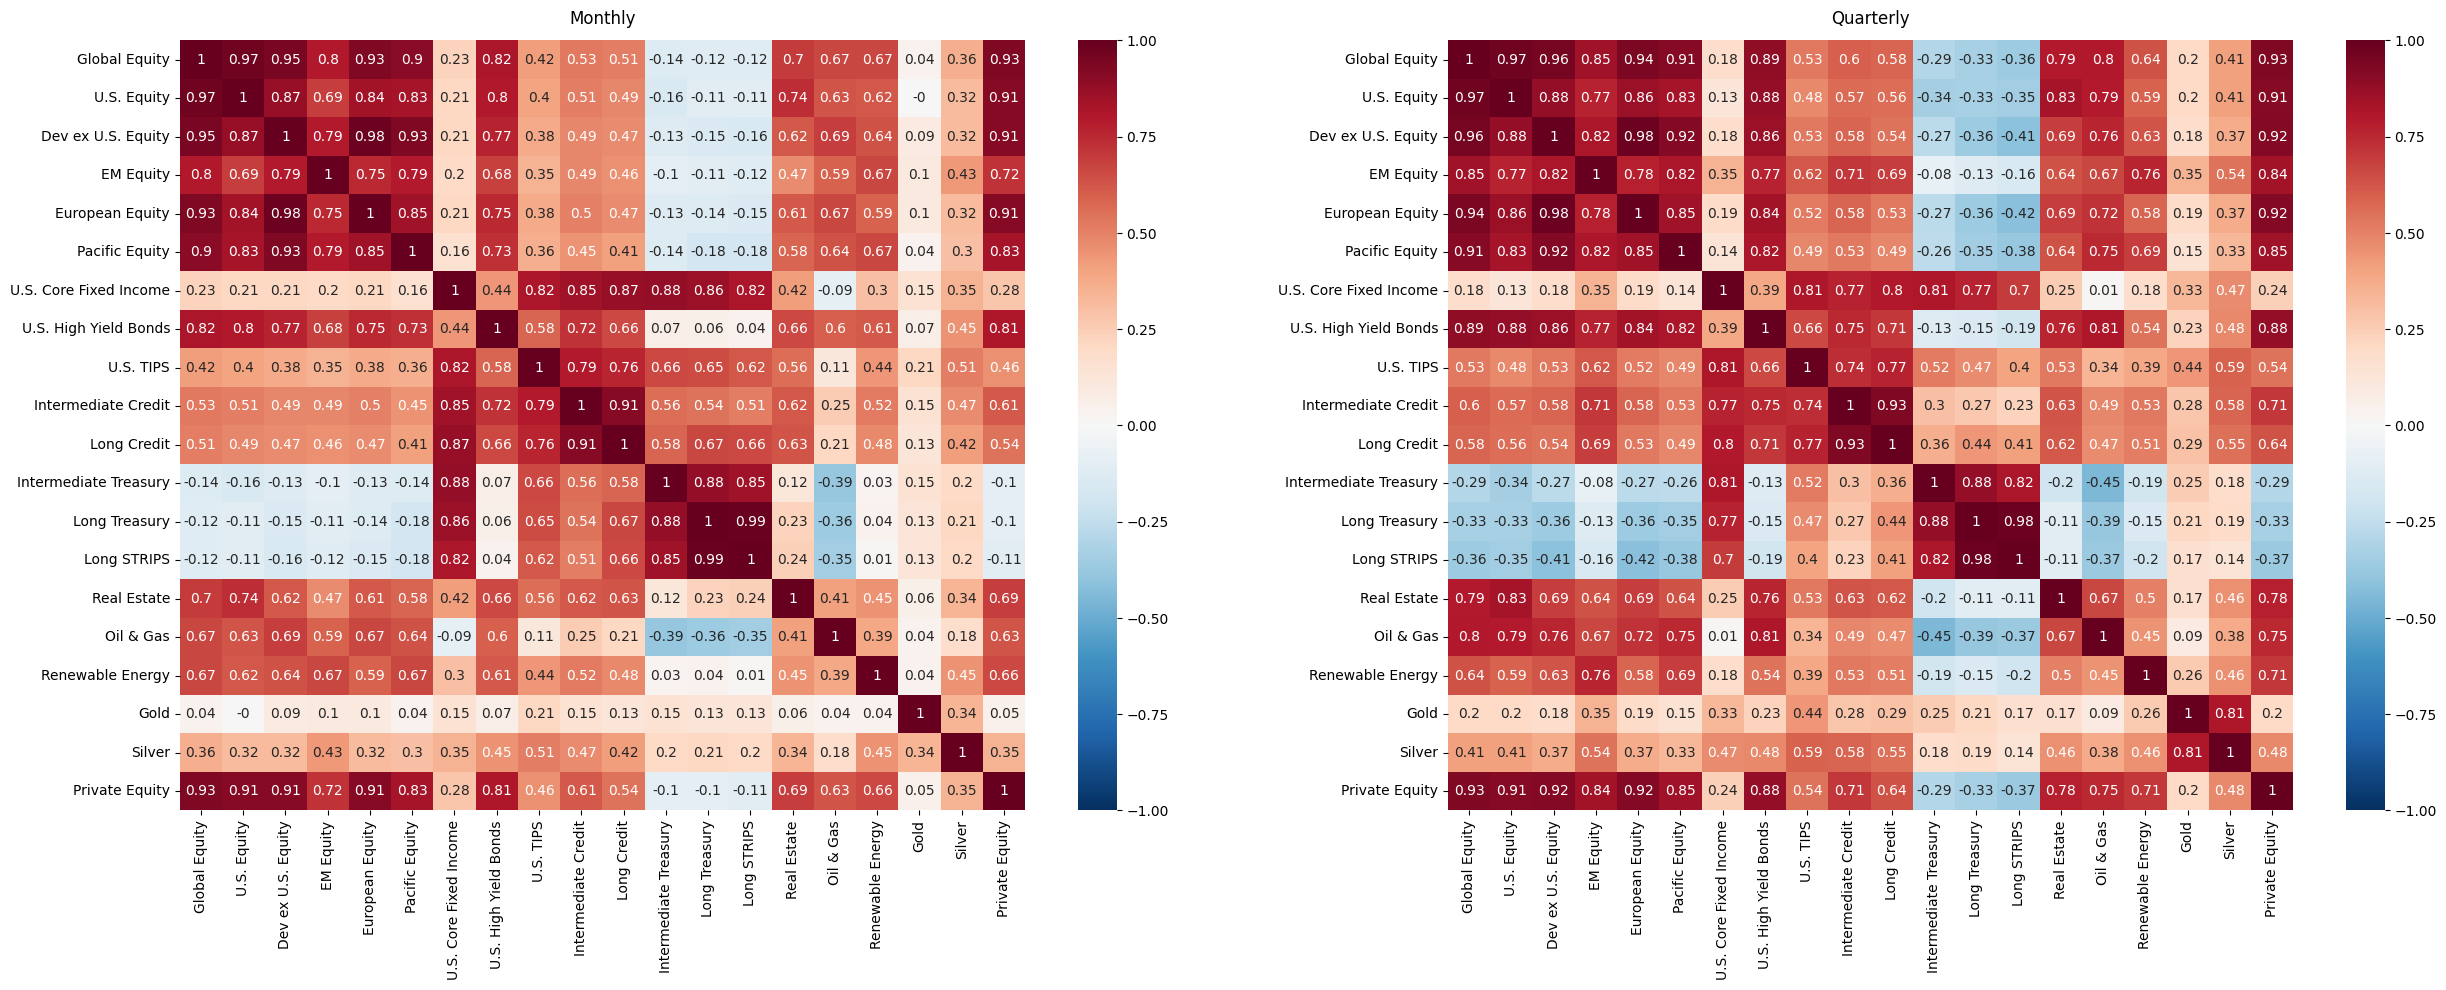

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(30, 10))

sns.heatmap(asset_class_corrs_m.round(2), vmax=1, vmin=-1, ax=axs[0], cmap='RdBu_r', annot=True)
axs[0].set_title('Monthly', pad=12)
sns.heatmap(asset_class_corrs_q.round(2), vmax=1, vmin=-1, ax=axs[1], cmap='RdBu_r', annot=True)
axs[1].set_title('Quarterly', pad=12)

plt.show()

### Converting correlation matrices into distance matrices

To convert correlations into distances, the following equation will be used:

$$d(x, y) = 1 - |r_{xy}|$$

Under this equation, correlations tending closer to either 1 or -1 will have a distance (dissimilarity) closer to 0, while correlations tending closer to zero will have a distance closer to 1&mdash;the maximum possible.

In [14]:
distance_matrix_m = 1-np.abs(asset_class_corrs_m)

# Cleaning up any infinitesimal negative values due to floating-point arithmetic
distance_matrix_m = np.abs(distance_matrix_m) 

distance_matrix_q = 1-np.abs(asset_class_corrs_q)
distance_matrix_q = np.abs(distance_matrix_q)
distance_matrix_q.round(2)

,Global Equity,U.S. Equity,Dev ex U.S. Equity,EM Equity,European Equity,Pacific Equity,U.S. Core Fixed Income,U.S. High Yield Bonds,U.S. TIPS,Intermediate Credit,Long Credit,Intermediate Treasury,Long Treasury,Long STRIPS,Real Estate,Oil & Gas,Renewable Energy,Gold,Silver,Private Equity
Global Equity,0.00,0.03,0.04,0.15,0.06,0.09,0.82,0.11,0.47,0.40,0.42,0.71,0.67,0.64,0.21,0.20,0.36,0.80,0.59,0.07
U.S. Equity,0.03,0.00,0.12,0.23,0.14,0.17,0.87,0.12,0.52,0.43,0.44,0.66,0.67,0.65,0.17,0.21,0.41,0.80,0.59,0.09
Dev ex U.S. Equity,0.04,0.12,0.00,0.18,0.02,0.08,0.82,0.14,0.47,0.42,0.46,0.73,0.64,0.59,0.31,0.24,0.37,0.82,0.63,0.08
EM Equity,0.15,0.23,0.18,0.00,0.22,0.18,0.65,0.23,0.38,0.29,0.31,0.92,0.87,0.84,0.36,0.33,0.24,0.65,0.46,0.16
European Equity,0.06,0.14,0.02,0.22,0.00,0.15,0.81,0.16,0.48,0.42,0.47,0.73,0.64,0.58,0.31,0.28,0.42,0.81,0.63,0.08
Pacific Equity,0.09,0.17,0.08,0.18,0.15,0.00,0.86,0.18,0.51,0.47,0.51,0.74,0.65,0.62,0.36,0.25,0.31,0.85,0.67,0.15
U.S. Core Fixed Income,0.82,0.87,0.82,0.65,0.81,0.86,0.00,0.61,0.19,0.23,0.20,0.19,0.23,0.30,0.75,0.99,0.82,0.67,0.53,0.76
U.S. High Yield Bonds,0.11,0.12,0.14,0.23,0.16,0.18,0.61,0.00,0.34,0.25,0.29,0.87,0.85,0.81,0.24,0.19,0.46,0.77,0.52,0.12
U.S. TIPS,0.47,0.52,0.47,0.38,0.48,0.51,0.19,0.34,0.00,0.26,0.23,0.48,0.53,0.60,0.47,0.66,0.61,0.56,0.41,0.46
Intermediate Credit,0.40,0.43,0.42,0.29,0.42,0.47,0.23,0.25,0.26,0.00,0.07,0.70,0.73,0.77,0.37,0.51,0.47,0.72,0.42,0.29


### Clustering and subsequent visualization (using a dendrogram)

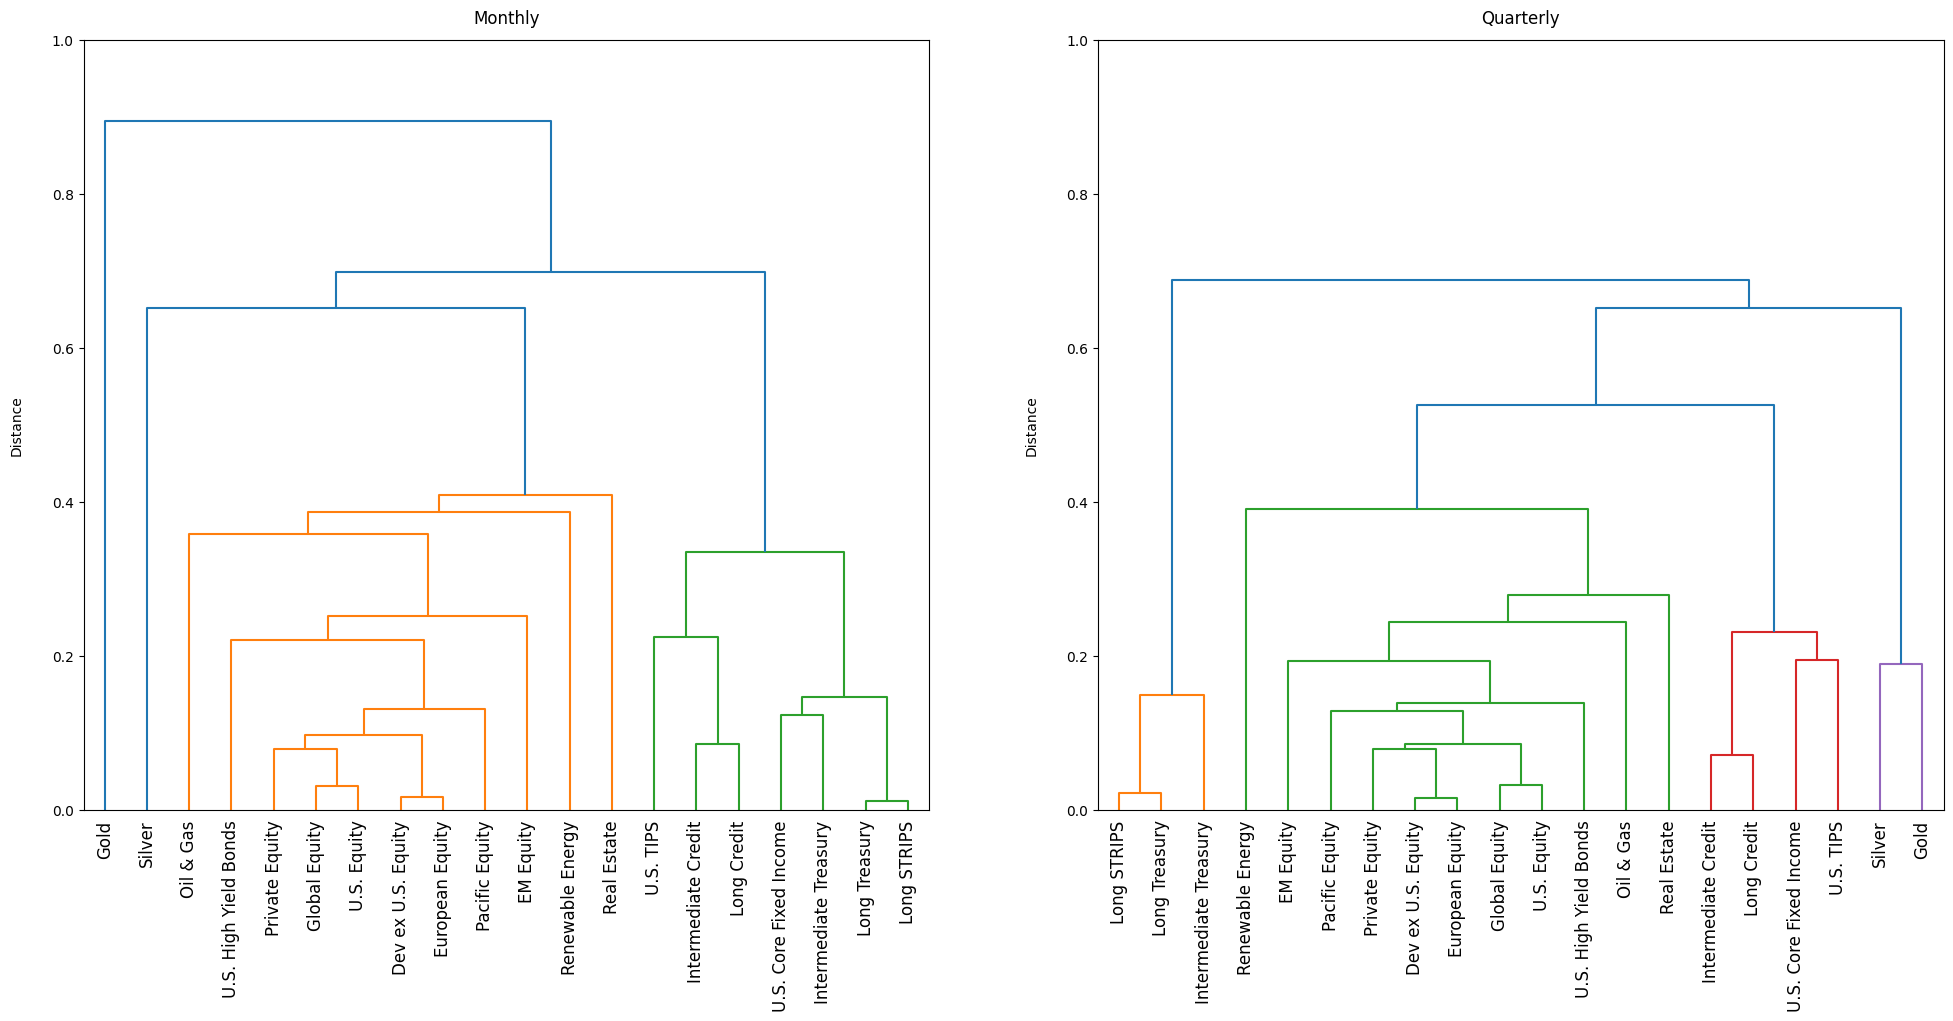

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(24, 10))

# Distance matrix is compressed using squareform(), then clustering performed using average linkage
Z_m = linkage(squareform(distance_matrix_m), 'average', optimal_ordering=True)

Z_q = linkage(squareform(distance_matrix_q), 'average', optimal_ordering=True)


labels_m = distance_matrix_m.index
dendrogram(Z_m, labels=labels_m, orientation='top', 
           leaf_rotation=90, ax=axs[0])

labels_q = distance_matrix_q.index
dendrogram(Z_q, labels=labels_q, orientation='top', 
           leaf_rotation=90, ax=axs[1])

axs[0].set_ylabel('Distance', labelpad=20)
axs[0].set_ylim((0, 1))
axs[0].set_title('Monthly', pad=12)

axs[1].set_ylabel('Distance', labelpad=20)
axs[1].set_ylim((0, 1))
axs[1].set_title('Quarterly', pad=12)


plt.show()

### Sorting correlation matrices based on respective hierarchical clusters

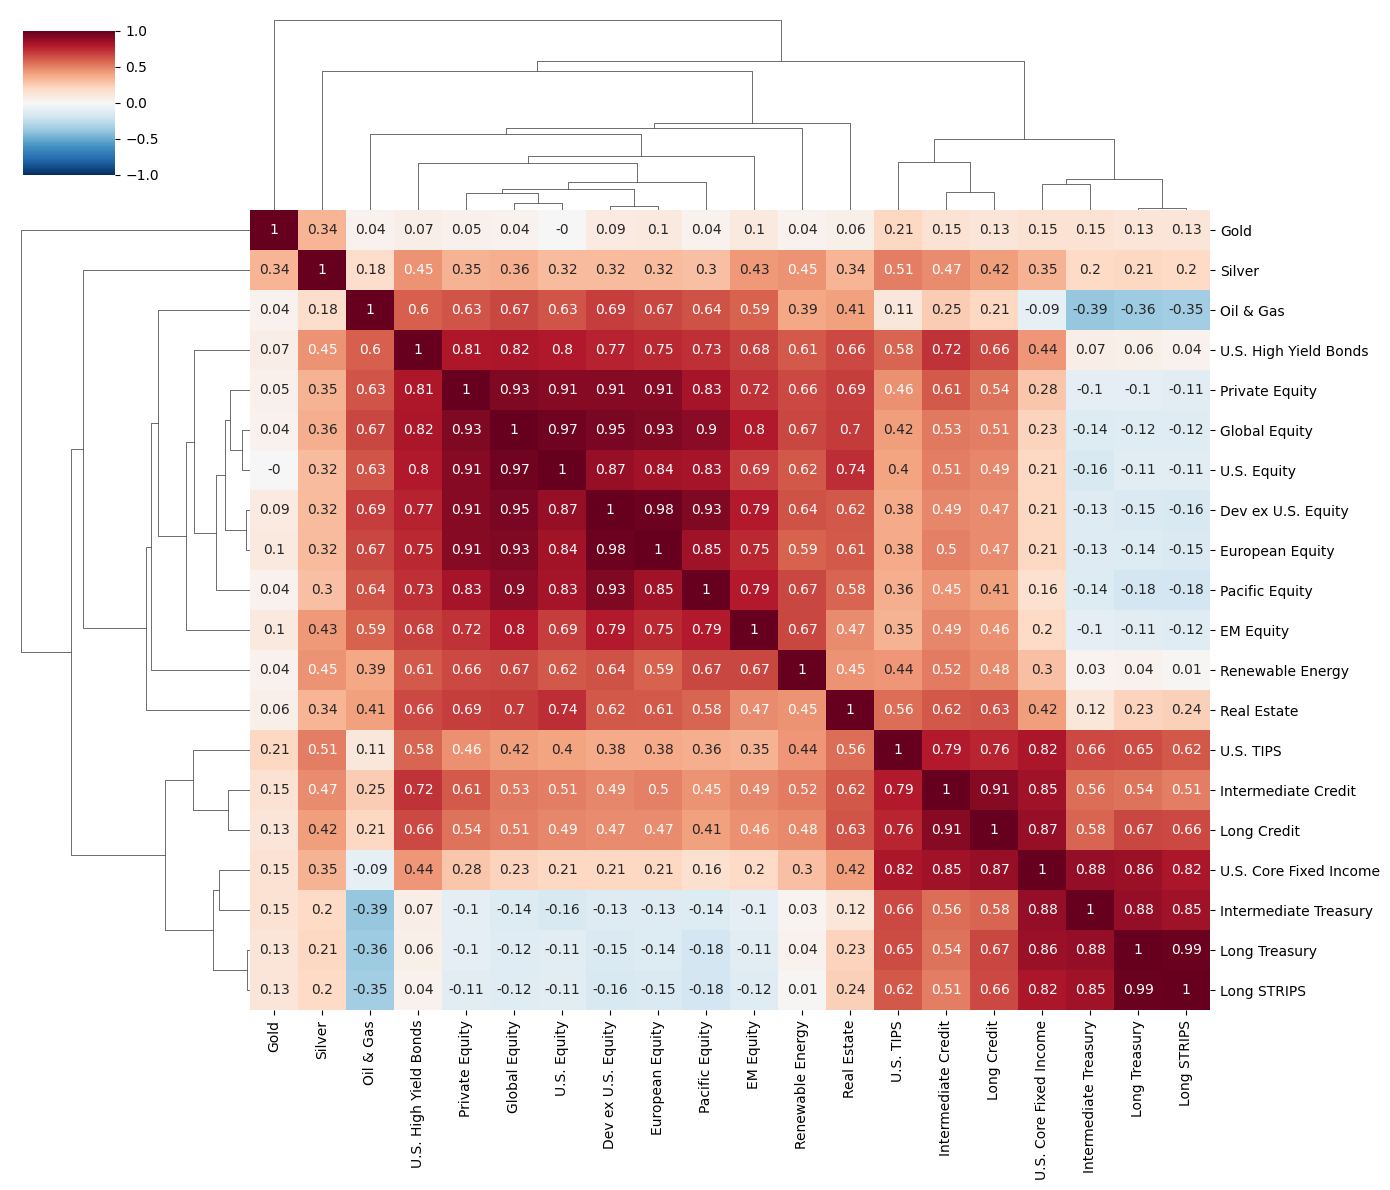

In [16]:
# Monthly

sns.clustermap(asset_class_corrs_m.round(2), row_linkage=Z_m, col_linkage=Z_m, vmax=1, vmin=-1, 
               cmap='RdBu_r', annot=True, figsize=(14, 12), cbar_pos=(0.02, 0.85, 0.066, 0.12))
plt.show()

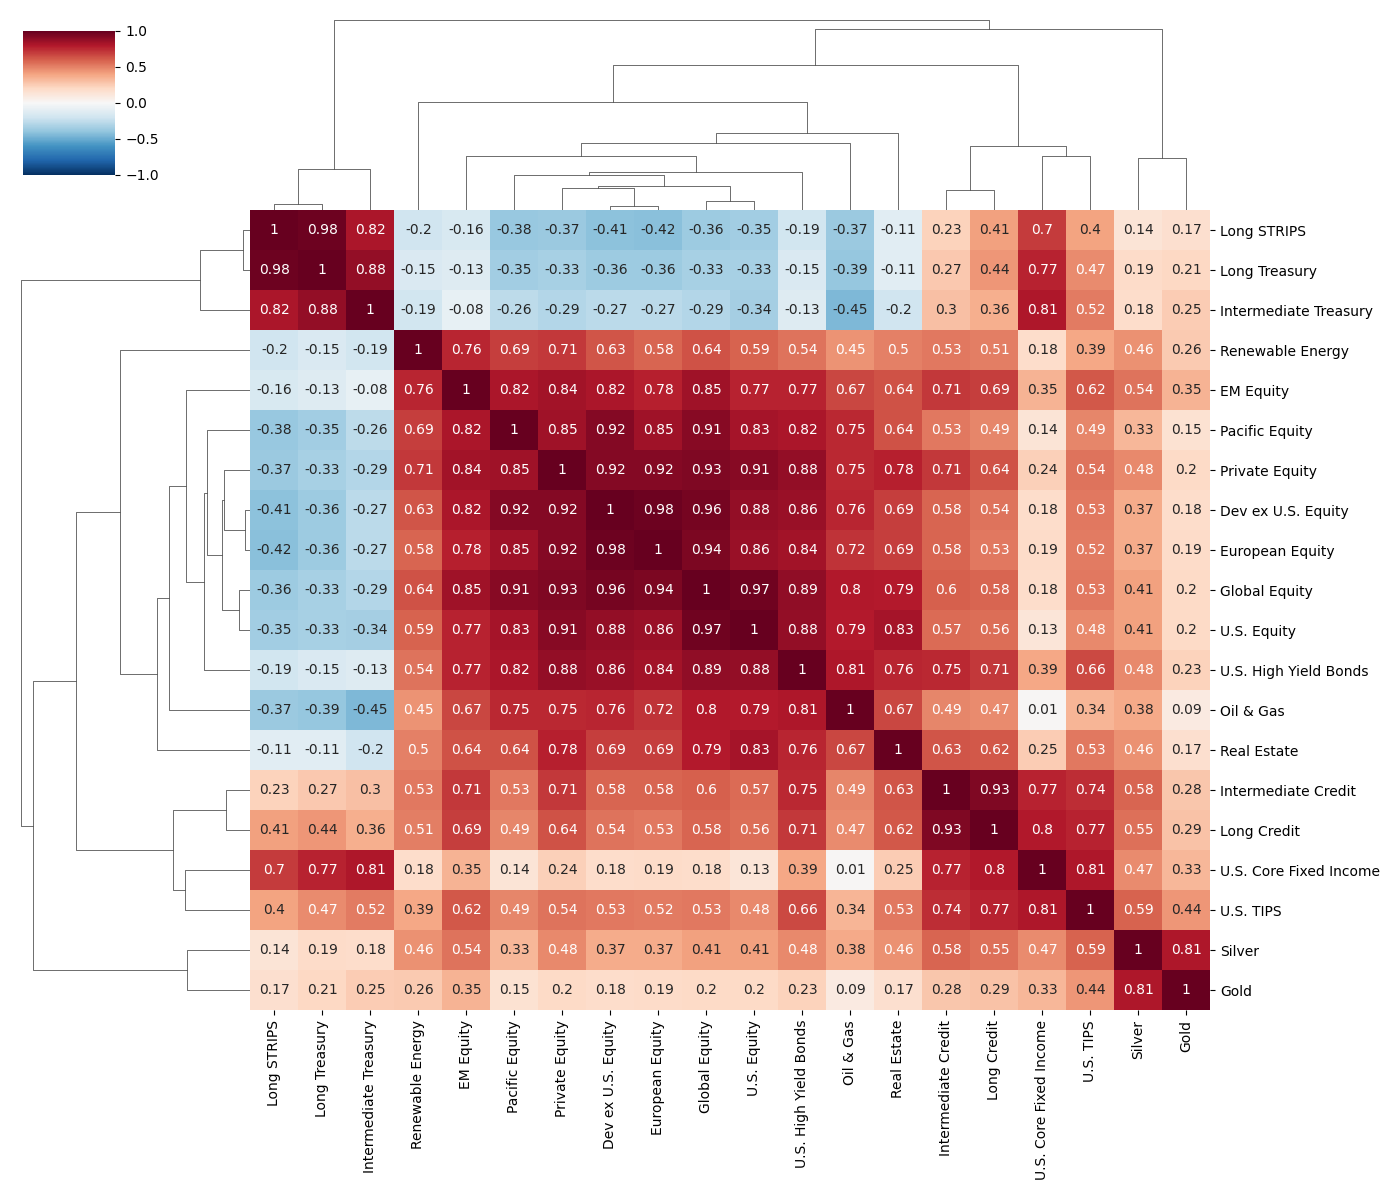

In [17]:
# Quarterly

sns.clustermap(asset_class_corrs_q.round(2), row_linkage=Z_q, col_linkage=Z_q, vmax=1, vmin=-1, 
               cmap='RdBu_r', annot=True, figsize=(14, 12), cbar_pos=(0.02, 0.85, 0.066, 0.12))
plt.show()

### Data Sources

Historical stock price data: API from [Alpha Vantage](https://www.alphavantage.co/)

### Tools Used

NumPy, Pandas, SciPy, Matplotlib, Seaborn, Requests